In [ ]:
# Test interpolation to connect 2 phrases

In [64]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import muspy

from generate import load_model, generate_z, generate_music, save
from utils import muspy_from_mtp, save_midi
from plots import plot_pianoroll, plot_structure

In [2]:
# Function to interpolate between two latent vectors
def interpolate_latents(z1, z2, steps=10):
    """Interpolate between two latent vectors z1 and z2."""
    interpolated_z = []
    for t in np.linspace(0, 1, steps):
        z_t = (1 - t) * z1 + t * z2
        interpolated_z.append(z_t)
    return torch.stack(interpolated_z)

In [5]:
device = torch.device("cuda")

In [8]:
model_dir = "models/POP8_4_150_kld_anneal"

In [10]:
model, configuration = load_model(model_dir, device)

In [15]:
configuration

{'batch_size': 32,
 'model': {'dropout': 0,
  'batch_norm': True,
  'gnn_n_layers': 8,
  'd': 512,
  'n_bars': 4,
  'resolution': 8},
 'optimizer': {'betas': [0.9, 0.98], 'eps': 1e-09, 'lr': 5e-06},
 'lr_scheduler': {'peak_lr': 0.0001,
  'final_lr_scale': 0.01,
  'warmup_steps': 1000,
  'decay_steps': 800000},
 'beta_scheduler': {'anneal_start': 5000,
  'beta_max': 0.01,
  'step_size': 0.001,
  'anneal_end': 25000}}

In [75]:
# Get latent vector for start phrase
z1 = generate_z(1, configuration['model']['d'], device)

# Get latent vector for end phrase
z2 = generate_z(1, configuration['model']['d'], device)

In [80]:
# Interpolate between 2 latent vectors
zi = interpolate_latents(z1, z2, steps=10)

In [70]:
def combine(zi, dir, s_tensor=None, n_loops=1, audio=True,
         looped_only=False, plot_proll=False, plot_struct=False):
    
    muspy_songs = []
    
    for idx in range(zi.shape[0]):
        mtp, s_tensor = generate_music(model, zi[idx])

        n_bars = mtp.size(1)
        resolution = mtp.size(3) // 4
        # Clear matplotlib cache (this solves formatting problems with first plot)
        plt.clf()

        os.makedirs(dir, exist_ok=True)
        if os.listdir(dir):
            print(f"list dir: {os.listdir(dir)}")
            curr_max_idx = max([eval(dir_num) for dir_num in os.listdir(dir)])
        else:
            curr_max_idx = -1

        # Iterate over batches
        for i in range(mtp.size(0)):

            # Create the directory if it does not exist
            save_dir = os.path.join(dir, str(i+curr_max_idx+1))
            os.makedirs(save_dir, exist_ok=True)

            if not looped_only:
                # Generate MIDI song from multitrack pianoroll and save
                muspy_songs.append(muspy_from_mtp(mtp[i]))
                # print("Saving MIDI sequence {} in {}...".format(str(i + 1), 
                #                                                 save_dir))
                # save_midi(muspy_song, save_dir, name='generated')
                # if audio:
                #     print("Saving audio sequence {} in {}...".format(str(i + 1),
                #                                                      save_dir))
                #     save_audio(muspy_song, save_dir, name='generated')

#             if plot_proll:
#                 plot_pianoroll(muspy_song, save_dir)

            if plot_struct:
                print(s_tensor[i].shape)
                plot_structure(s_tensor[i].cpu(), save_dir)

            # if n_loops > 1:
            #     # Copy the generated sequence n_loops times and save the looped
            #     # MIDI and audio files
            #     print("Saving MIDI sequence "
            #           "{} looped {} times in {}...".format(str(i + 1), n_loops,
            #                                                save_dir))
            #     extended = loop_muspy_music(muspy_song, n_loops, 
            #                                  n_bars, resolution)
            #     save_midi(extended, save_dir, name='extended')
            #     if audio:
            #         print("Saving audio sequence "
            #               "{} looped {} times in {}...".format(str(i + 1), n_loops,
            #                                                    save_dir))
            #         save_audio(extended, save_dir, name='extended')

            print()
    
    # # Create a new empty song
    # combined_song = muspy.Music()
    # # Combine the tracks from all songs
    # for song in muspy_songs:
    #     for track in song.tracks:
    #         # Copy track to avoid modifying the original song
    #         new_track = track.copy()
    #         combined_song.tracks.append(new_track)
            
    # Create a new empty song
    combined_song = muspy.Music()
    # Keep track of the current end time
    current_time = 0

    # Concatenate the tracks along the time axis
    for song in muspy_songs:
        for track in song.tracks:
            new_track = track.copy()
            for note in new_track.notes:
                note.time += current_time
            combined_song.tracks.append(new_track)
        # Update current_time to the end of the last song
        current_time += max(note.time for track in song.tracks for note in track.notes)

    # Copy over other attributes like resolution and metadata from the first song
    combined_song.metadata = songs[0].metadata
    combined_song.resolution = songs[0].resolution
    
            
    save_midi(combined_song, save_dir, name='generated')
    if plot_proll:
        plot_pianoroll(combined_song, save_dir)


list dir: ['6', '10', '3', '17', '34', '22', '13', '1', '35', '7', '14', '32', '27', '15', '30', '4', '12', '5', '18', '33', '11', '39', '31', '25', '38', '21', '28', '23', '16', '37', '9', '8', '29', '36', '2', '20', '24', '19', '26', '0']
torch.Size([4, 3, 32])

list dir: ['6', '10', '3', '17', '40', '34', '22', '13', '1', '35', '7', '14', '32', '27', '15', '30', '4', '12', '5', '18', '33', '11', '39', '31', '25', '38', '21', '28', '23', '16', '37', '9', '8', '29', '36', '2', '20', '24', '19', '26', '0']
torch.Size([4, 3, 32])

list dir: ['6', '10', '3', '17', '40', '34', '22', '13', '41', '1', '35', '7', '14', '32', '27', '15', '30', '4', '12', '5', '18', '33', '11', '39', '31', '25', '38', '21', '28', '23', '16', '37', '9', '8', '29', '36', '2', '20', '24', '19', '26', '0']
torch.Size([4, 3, 32])

list dir: ['6', '10', '3', '17', '40', '34', '22', '13', '41', '1', '35', '7', '14', '32', '27', '15', '30', '4', '12', '5', '18', '33', '11', '39', '31', '25', '42', '38', '21', '28', '2

IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

<Figure size 864x216 with 0 Axes>

<Figure size 864x216 with 0 Axes>

<Figure size 864x216 with 0 Axes>

<Figure size 864x216 with 0 Axes>

<Figure size 864x216 with 0 Axes>

<Figure size 864x216 with 0 Axes>

<Figure size 864x216 with 0 Axes>

<Figure size 864x216 with 0 Axes>

<Figure size 864x216 with 0 Axes>

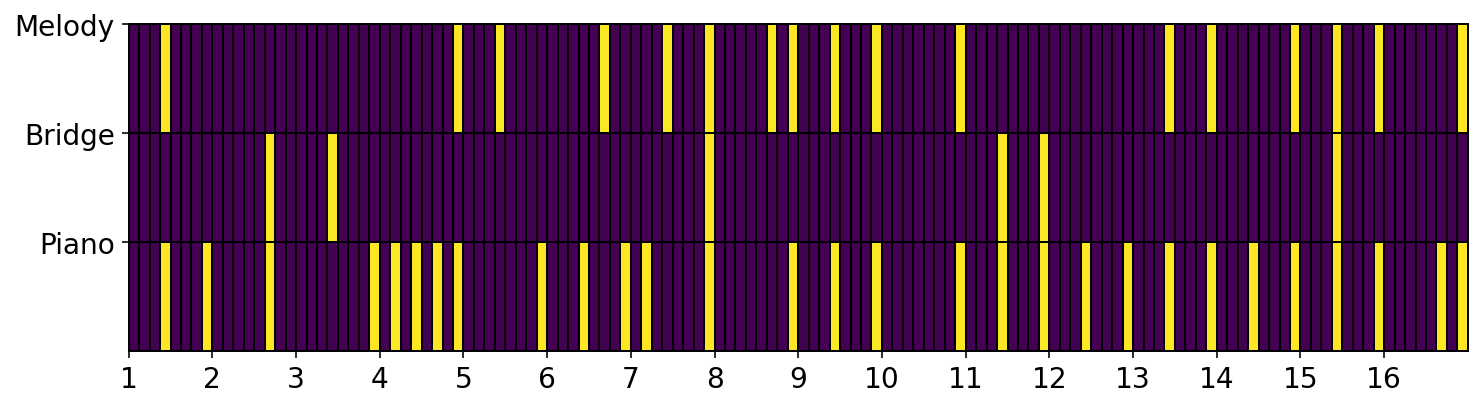

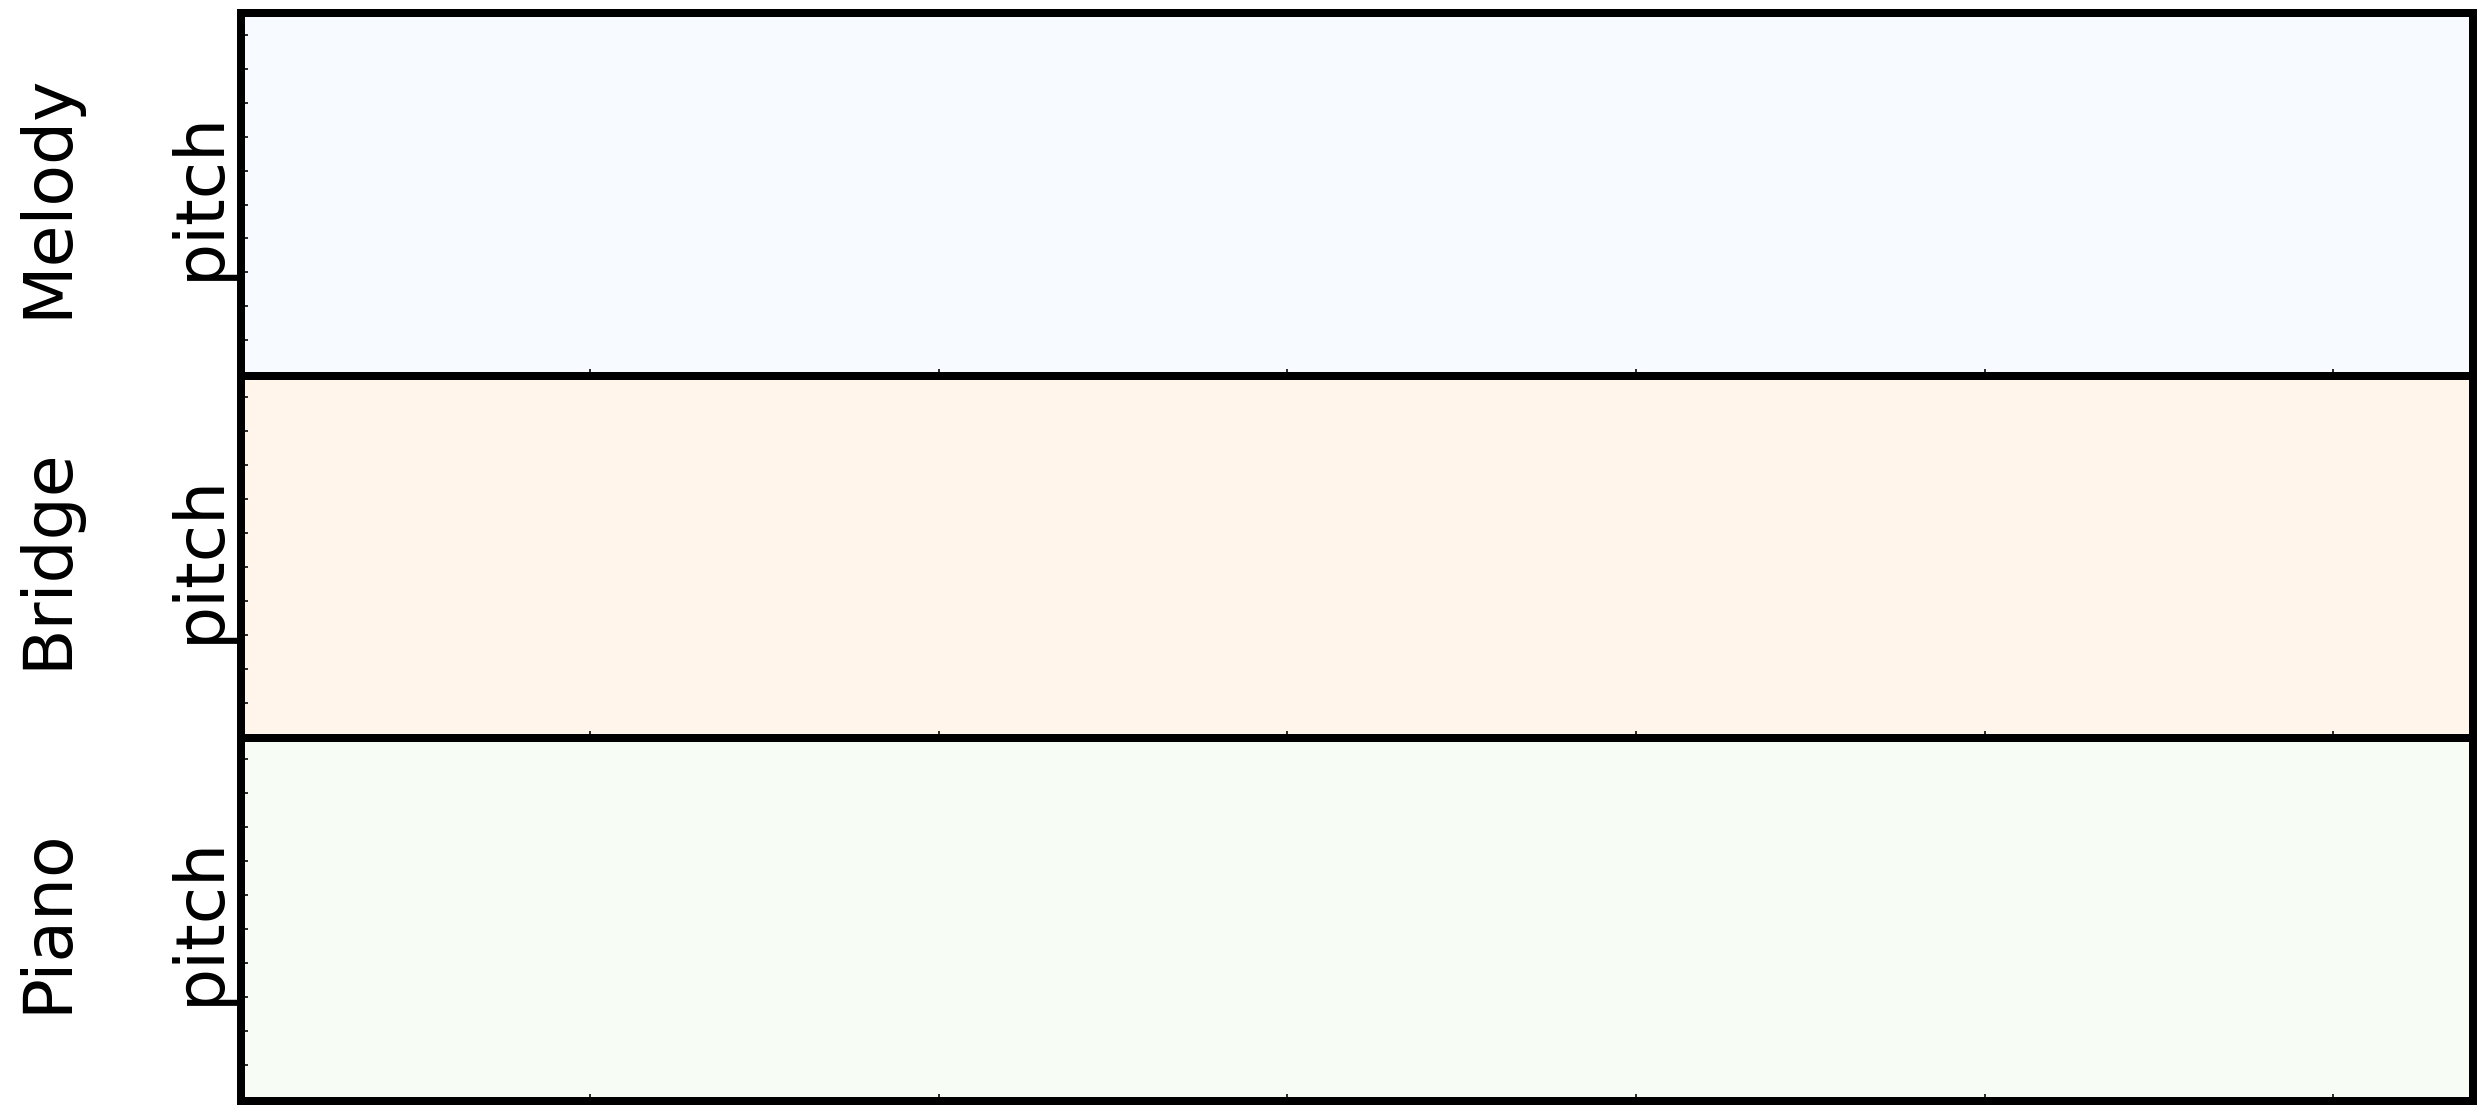

In [81]:
combine(zi, "generate_interpolate", s_tensor=None, n_loops=1, audio=False,
         looped_only=False, plot_proll=True, plot_struct=True)